In [1]:
import os
from astropy.visualization import ImageNormalize, LinearStretch, ZScaleInterval
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
from astropy.stats import sigma_clip
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry, ApertureStats
from photutils.datasets import make_noise_image
from astroscrappy import detect_cosmics
from astropy.table import Table

In [2]:
os.getcwd()

'/home/jovyan/ARCSAT'

In [3]:
def create_median_bias(median_bias_filename):   
    bias_images = []
    bias_list=[os.path.join('/home/jovyan/ARCSAT/Files/Bias', f) for f in os.listdir('/home/jovyan/ARCSAT/Files/Bias') if f.endswith('.fits')]
    for bias_file in bias_list:
        bias_data = fits.getdata(bias_file)
        bias_images.append(bias_data.astype('f4'))
        
    bias_images_3d = np.array(bias_images)
    bias_mean_2d = np.mean(bias_images_3d, axis=0)
    bias_images_masked = sigma_clip(bias_images_3d, cenfunc='median', sigma=2.5, axis=0)
    median_bias = np.ma.mean(bias_images_masked, axis=0)
    better_bias = median_bias.filled(np.nan)

    primary = fits.PrimaryHDU(data=better_bias, header=fits.Header())
    hdul = fits.HDUList([primary])
    hdul.writeto(median_bias_filename, overwrite=True)

    return better_bias

In [4]:
median_bias_filename = 'output_median_bias.fits'

In [5]:
create_median_bias(median_bias_filename)

array([[1353.88888889, 1349.5       , 1360.6       , ..., 1345.88888889,
        1357.4       , 1359.3       ],
       [1315.4       , 1322.9       , 1310.77777778, ..., 1324.6       ,
        1316.8       , 1316.44444444],
       [1338.4       , 1338.        , 1333.        , ..., 1333.        ,
        1340.4       , 1334.1       ],
       ...,
       [1352.55555556, 1350.2       , 1354.6       , ..., 1361.4       ,
        1351.33333333, 1358.88888889],
       [1354.1       , 1350.5       , 1362.        , ..., 1361.1       ,
        1354.66666667, 1351.        ],
       [1360.4       , 1353.3       , 1357.3       , ..., 1355.7       ,
        1351.1       , 1363.8       ]], shape=(1024, 1024))

In [6]:
def create_median_dark(median_dark_filename, median_bias_filename):
    dark_images = []
    dark_list=[os.path.join('/home/jovyan/ARCSAT/Files/Dark', f) for f in os.listdir('/home/jovyan/ARCSAT/Files/Dark') if f.endswith('.fits')]

    for dark_file in dark_list:
        with fits.open(dark_file) as hdul:
            dark_data = hdul[0].data.astype('f4')
            header = hdul[0].header
            exptime = header['EXPTIME']
            data_normalized = (dark_data/exptime)
            dark_images.append(data_normalized)
    with fits.open(median_bias_filename) as bias_hdul:
        better_bias = bias_hdul[0].data.astype('f4')

    dark_array = np.array(dark_images)

    dark_data_no_bias = (dark_array - better_bias)
    dark_sigma_clip = sigma_clip(dark_data_no_bias, cenfunc='median', sigma=3, axis=0)
    median_dark = np.ma.median(dark_sigma_clip, axis=0)
    better_median_dark = median_dark.filled(0.0)

    primary = fits.PrimaryHDU(data=better_median_dark)
    hdul = fits.HDUList([primary])
    hdul.writeto(median_dark_filename, overwrite=True)

    return better_median_dark

In [7]:
median_dark_filename = 'output_median_dark.fits'

In [8]:
create_median_dark(median_dark_filename, median_bias_filename)

array([[-1331.3055, -1326.7833, -1337.7832, ..., -1323.239 , -1334.6833,
        -1336.6667],
       [-1293.3417, -1300.9333, -1288.8779, ..., -1302.3416, -1294.875 ,
        -1294.4695],
       [-1316.2417, -1315.7749, -1310.8916, ..., -1310.6833, -1318.2168,
        -1311.9333],
       ...,
       [-1330.0305, -1327.5833, -1332.0499, ..., -1338.9   , -1328.7334,
        -1336.3055],
       [-1331.3833, -1327.3417, -1339.2583, ..., -1338.3999, -1332.0999,
        -1328.3667],
       [-1337.7167, -1330.6417, -1334.6001, ..., -1332.6665, -1328.3999,
        -1341.2417]], shape=(1024, 1024), dtype=float32)

In [9]:
def create_median_flat(median_bias_filename, median_flat_filename, median_dark_filename=None):  
    flats_g = []
    flat_list=[os.path.join('/home/jovyan/ARCSAT/Files/Domeflat', f) for f in os.listdir('/home/jovyan/ARCSAT/Files/Domeflat') if f.endswith('.fits')]

    for flat_file in flat_list:
        with fits.open(flat_file) as hdul:
            flats_g.append(hdul[0].data)
        with fits.open(median_bias_filename) as bias_hdul:
            bias_data = bias_hdul[0].data.astype('f4')
        if median_dark_filename:
            with fits.open(dark_filename) as dark_hdul:
                dark_data = dark_hdul[0].data.astype('f4')
                exposure_time = np.median([fits.getheader(f)[0]['EXPTIME'] for f in flat_list])
            
    flats_g_masked = sigma_clip(flats_g, cenfunc='median', sigma=3, axis=0)
    flat_g_combined = np.ma.median(flats_g_masked, axis=0).data
    median_flat_value = np.median(flat_g_combined)
    
    median_flat = flat_g_combined/median_flat_value

    primary = fits.PrimaryHDU(data=median_flat, header=fits.Header())
    hdul = fits.HDUList([primary])
    hdul.writeto(median_flat_filename, overwrite=True)

    return median_flat

In [10]:
median_flat_filename = 'output_median_flat.fits'

In [11]:
create_median_flat(median_bias_filename, median_flat_filename, median_dark_filename=None)

array([[1.00978277, 1.02172277, 0.99816887, ..., 1.02588672, 1.04868811,
        1.0436713 ],
       [0.97253299, 0.9624492 , 0.97546782, ..., 0.98374555, 0.97667185,
        0.97810164],
       [0.96774194, 0.96219836, 0.97601967, ..., 0.97712336, 0.98045954,
        0.98447298],
       ...,
       [1.02295189, 1.01073597, 1.01793508, ..., 1.03027643, 1.03805248,
        1.03599559],
       [1.01801033, 1.00654693, 1.02663924, ..., 1.03479155, 1.03602067,
        1.02852054],
       [1.0125671 , 1.0091055 , 1.02382983, ..., 1.04179   , 1.02969949,
        1.03291025]], shape=(1024, 1024))

In [12]:
def plot_flat(median_flat_filename, profile_output_filename="median_flat_profile.png"):
    with fits.open(median_flat_filename) as hdul:
        median_flat = hdul[0].data
        
    plt.figure(figsize=(12, 8))
    vmin = np.percentile(median_flat, 5)
    vmax = np.percentile(median_flat, 95)
    plt.imshow(median_flat, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
    plt.savefig(output_filename)
    median_y = np.median(median_flat, axis=0)
    
    plt.figure(figsize=(12, 8))
    plt.plot(median_y)
    
    plt.savefig(profile_output_filename)
    return

In [13]:
profile_output_filename="median_flat_profile.png"
output_filename="median_flat.png"

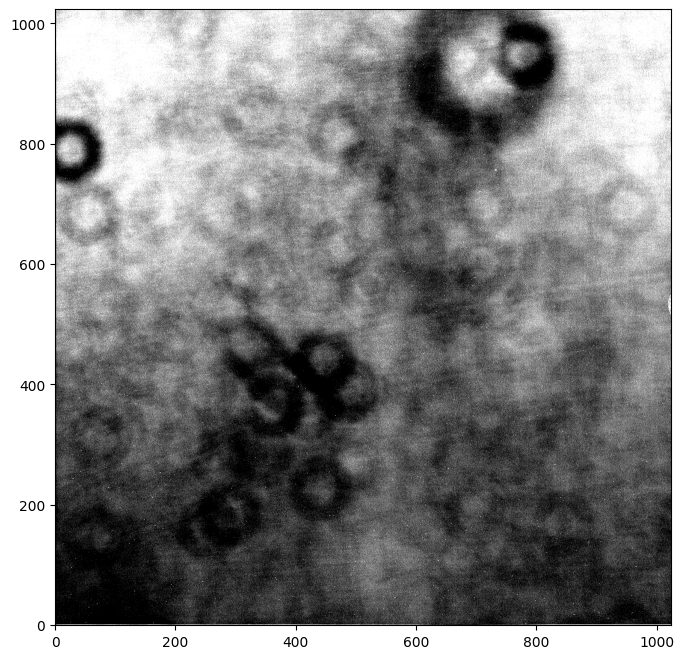

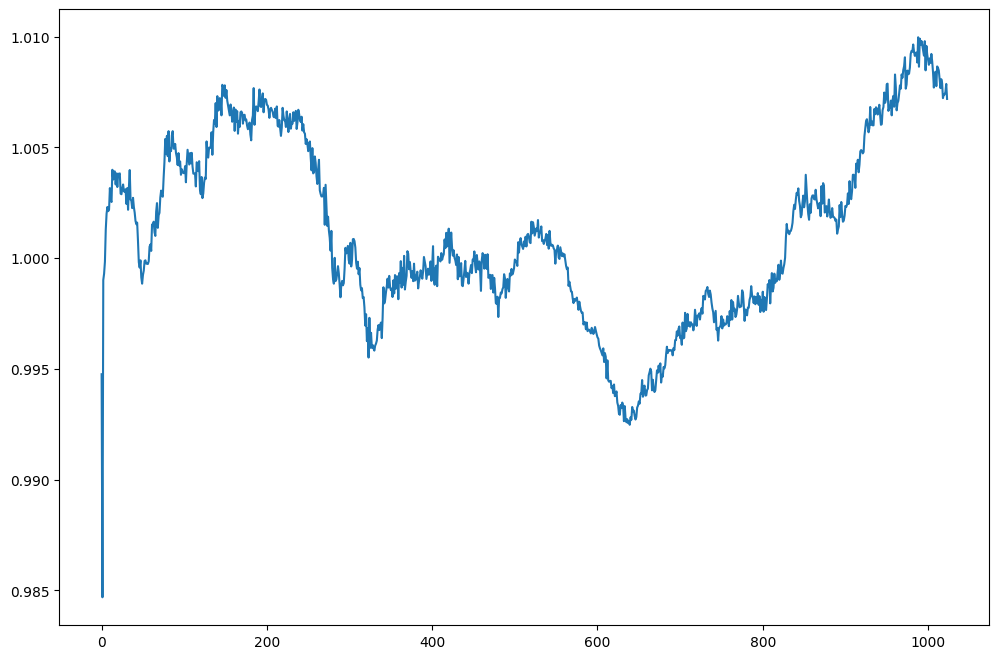

In [14]:
 plot_flat(median_flat_filename, profile_output_filename="median_flat_profile.png")

In [15]:
def calculate_gain():
    
    science1 = fits.getdata('/home/jovyan/ARCSAT/Files/x01/XO1-b_z_20250602_042752.fits')
    science2 = fits.getdata('/home/jovyan/ARCSAT/Files/x01/XO1-b_z_20250602_052845.fits')
    mean_signal = np.mean(science1+science2)
    flat_diff = science1 - science2
    flat_diff_var = np.var(flat_diff)

    gain = 2 * mean_signal / flat_diff_var

    return gain

gain = calculate_gain()
def calculate_readout_noise(gain):
    
    science1 = fits.getdata('/home/jovyan/ARCSAT/Files/x01/XO1-b_z_20250602_042752.fits')
    science2 = fits.getdata('/home/jovyan/ARCSAT/Files/x01/XO1-b_z_20250602_052845.fits')
    flat_diff = science1 - science2
    flat_diff_var = np.var(flat_diff)

    readout_noise = np.sqrt(flat_diff_var / 2)

    return readout_noise

In [16]:
gain

np.float64(5.621158968389575e-06)

In [17]:
calculate_readout_noise(gain)

np.float64(22950.79017674195)

In [18]:
def reduce_science_frame(median_bias_filename, median_flat_filename, median_dark_filename, reduced_science_filename="reduced_science.fits"):

    science_files = [
        '/home/jovyan/ARCSAT/Files/x01/XO1-b_z_20250602_042752.fits',
        '/home/jovyan/ARCSAT/Files/x01/XO1-b_z_20250602_052845.fits'
    ]
    with fits.open(science_files[0]) as hdul:
        science_data = hdul[0].data.astype('f4')
        exptime = hdul[0].header['EXPTIME']
    bias_data = fits.getdata(median_bias_filename).astype('f4')
    flat_data = fits.getdata(median_flat_filename).astype('f4')
    dark_data = fits.getdata(median_dark_filename).astype('f4')

    science_data_proc = science_data - bias_data
    dark_data_scaled = dark_data * exptime
    science_data_proc -= dark_data_scaled
    science_data_proc /= flat_data
    cosmic_mask, reduced_science = detect_cosmics(science_data_proc)

    primary = fits.PrimaryHDU(data=reduced_science, header=fits.Header())
    hdul = fits.HDUList([primary])
    hdul.writeto(reduced_science_filename, overwrite=True)

    return reduced_science

In [19]:
reduce_science_frame(median_bias_filename, median_flat_filename, median_dark_filename, reduced_science_filename="reduced_science.fits")

array([[79219.46 , 78049.055, 80553.89 , ..., 77568.45 , 76480.9  ,
        77032.6  ],
       [79899.71 , 81208.55 , 79370.01 , ..., 79536.71 , 79635.445,
        79525.2  ],
       [81739.875, 82176.914, 80707.9  , ..., 80594.734, 80774.99 ,
        80115.86 ],
       ...,
       [78148.62 , 78899.72 , 78632.12 , ..., 78071.87 , 76952.44 ,
        77602.11 ],
       [78603.23 , 79276.98 , 78386.35 , ..., 77742.12 , 77355.92 ,
        77708.7  ],
       [79372.125, 79224.83 , 78371.14 , ..., 76912.13 , 77639.055,
        78278.54 ]], shape=(1024, 1024), dtype=float32)

In [23]:
def do_aperture_photometry(positions, radii, sky_radius_in, sky_annulus_width):
    photometry = []
    with fits.open('/home/jovyan/ARCSAT/reduced_science.fits') as image:
        reduced_file_data = image[0].data.astype('f4')

    for pos in positions:
        xc, yc = pos
        aperture = CircularAperture((xc, yc), r=radii[0])
        sky_annulus = CircularAnnulus((xc, yc), r_in=sky_radius_in, r_out=sky_radius_in + sky_annulus_width)
        annulus_stats = ApertureStats(reduced_file_data, sky_annulus)
        back = annulus_stats.median
        std = annulus_stats.std
        
        phot_table = aperture_photometry(reduced_file_data, aperture)
        flux = phot_table['aperture_sum'][0]
        aperture_area = aperture.area_overlap(reduced_file_data)
        flux_no_back = flux - back * aperture_area

        photometry.append({
            'x': xc,
            'y': yc,
            'radius': radii[0],
            'flux': flux_no_back,
            'background': back,
            'skyflux': flux,
        })

    aperture_photometry_data = Table(rows=photometry, names=('x', 'y', 'radius', 'flux', 'background', 'skyflux'))

    return aperture_photometry_data
positions = [(536, 563), (414, 261)]
radii = [5.0]
sky_radius_in = 8.0
sky_annulus_width = 3.0

do_aperture_photometry(positions, radii, sky_radius_in, sky_annulus_width)

x,y,radius,flux,background,skyflux
int64,int64,float64,float64,float64,float64
536,563,5.0,211009.27556010988,80299.734375,6517735.665502906
414,261,5.0,182991.1274492871,81714.390625,6600824.359450955


In [21]:
def plot_radial_profile(aperture_photometry_data, output_filename="radial_profile.png"):
    radii = aperture_photometry_data['radius']
    flux = aperture_photometry_data['flux']

    plt.figure(figsize=(12, 8))

    plt.plot(radii, flux, label='Target', color='b', marker='o')

    sky_radius_out = sky_radius_in + sky_annulus_width
    plt.axvline(x=sky_radius_in, color='r', linestyle='--', label=f'Sky aperture radius: {sky_radius_in} px')
    plt.axvline(x=sky_radius_out, color='r', linestyle='--', label=f'Sky aperture outer: {sky_radius_out} px')

    plt.savefig(output_filename)
    plt.close()

    pass
aperture_photometry_data = do_aperture_photometry(positions, radii, sky_radius_in, sky_annulus_width)
plot_radial_profile(aperture_photometry_data, output_filename="radial_profile.png")

{'reduce_science': array([[79219.46 , 78049.055, 80553.89 , ..., 77568.45 , 76480.9  ,
         77032.6  ],
        [79899.71 , 81208.55 , 79370.01 , ..., 79536.71 , 79635.445,
         79525.2  ],
        [81739.875, 82176.914, 80707.9  , ..., 80594.734, 80774.99 ,
         80115.86 ],
        ...,
        [78148.62 , 78899.72 , 78632.12 , ..., 78071.87 , 76952.44 ,
         77602.11 ],
        [78603.23 , 79276.98 , 78386.35 , ..., 77742.12 , 77355.92 ,
         77708.7  ],
        [79372.125, 79224.83 , 78371.14 , ..., 76912.13 , 77639.055,
         78278.54 ]], shape=(1024, 1024), dtype=float32),
 'gain': np.float64(5.621158968389575e-06),
 'noise': np.float64(22950.79017674195),
 'photometry': <Table length=2>
   x     y    radius        flux          background        skyflux     
 int64 int64 float64      float64          float64          float64     
 ----- ----- ------- ------------------ -------------- -----------------
   526   572     5.0  948.8115743165836 80093.96484375 6

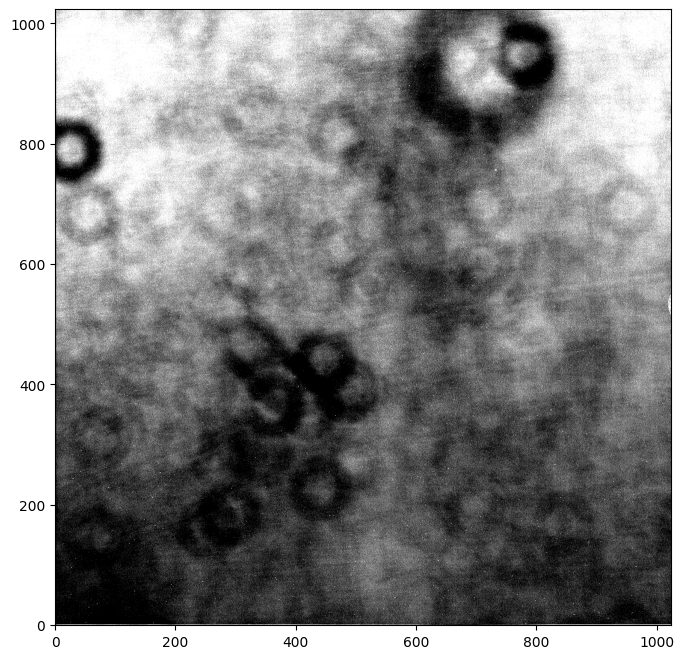

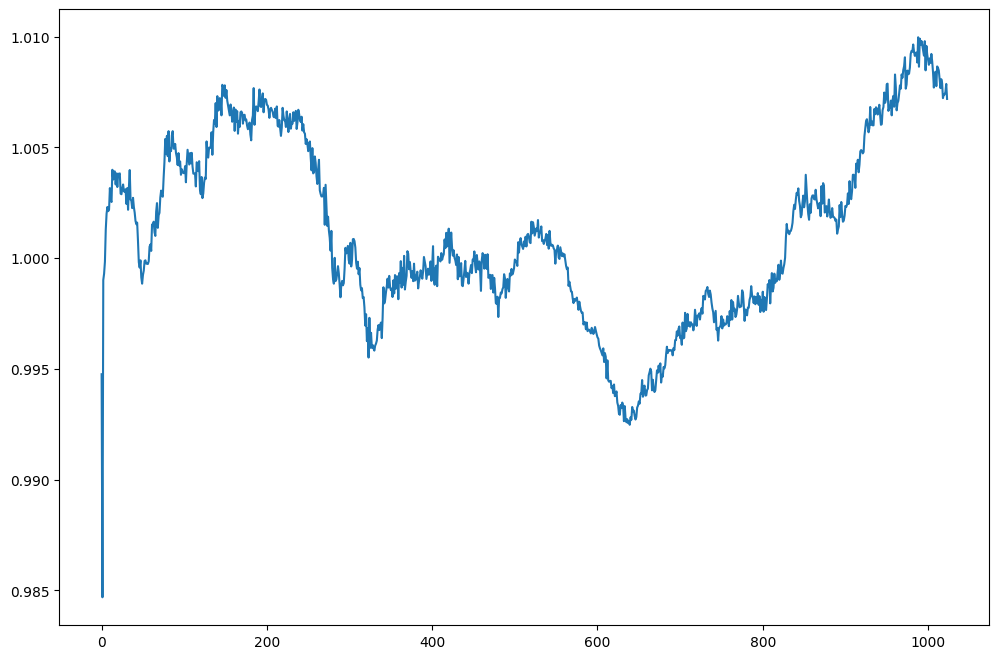

In [22]:
def run_reduction():
    median_bias = create_median_bias(median_bias_filename)
    median_dark = create_median_dark(median_dark_filename, median_bias_filename)
    median_flat = create_median_flat(median_bias_filename, median_flat_filename, median_dark_filename=None)
    plot_flat(median_flat_filename, profile_output_filename="median_flat_profile.png")
    photometry = do_aperture_photometry(positions, radii, sky_radius_in, sky_annulus_width)
    gain = calculate_gain()
    noise = calculate_readout_noise(gain)
    reduce_science = reduce_science_frame(median_bias_filename, median_flat_filename, median_dark_filename, reduced_science_filename="reduced_science.fits")
    plot_radial_profile(aperture_photometry_data, output_filename="radial_profile.png")

    result={
        'reduce_science': reduce_science,
        'gain': gain,
        'noise':noise,
        'photometry':photometry,
        'median_flat': median_flat,
        'median_dark': median_dark,
        'median_bias': median_bias
    }

    return result
run_reduction()